In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import deepxde as dde
from deepxde.backend import tf
import seaborn as sns

%matplotlib inline

sns.set_context("talk")
dde.config.set_default_float("float64")
dde.config.set_random_seed(0)

x_max = 1e-3
y_max = 0.23e-3
t_max = 0.001

geo = dde.geometry.Hypercube((0.0, 0.0), (x_max, y_max))
time = dde.geometry.TimeDomain(0, t_max)
domain = dde.geometry.GeometryXTime(geo, time)

A = 0.09
D = 140e-6
R = D/2
P = 250
v = 200e-3
T_n = 301.3
T_h = 1500

def pde_system(X, output):
    
    T = output
    
    dT_dx = dde.grad.jacobian(T, X, j = 0)
    dT_dy = dde.grad.jacobian(T, X, j = 1)
    dT_dt = dde.grad.jacobian(T, X, j = 2)
    
    k = tf.cast(11.82+1.06e-2*T, 'float64')
    c = tf.cast(330.9+0.563*T-4.015e-4*T**2+9.465e-8*T**3, 'float64')
    rho = tf.cast(7800.0*T**0, 'float64')
    
    k_eff = k
    rho_eff = rho
    
    diff_T = dde.grad.jacobian(k_eff*dT_dx, X, j = 0) + dde.grad.jacobian(k_eff*dT_dy, X, j=1)
    
    f_T = (rho_eff*c)*dT_dt - diff_T
        
    return f_T

ic = dde.icbc.IC(domain, lambda on_initial: T_n, lambda x, on_initial: on_initial and not np.isclose(x[1], y_max, atol=y_max/20))
top = dde.icbc.DirichletBC(domain, lambda X : T_h, lambda x, on_boundary: on_boundary and np.isclose(x[1], y_max, atol=y_max/20))
sides = dde.icbc.DirichletBC(domain, lambda X : T_n, lambda x, on_boundary: on_boundary and not np.isclose(x[1], y_max, atol=y_max/20))

geo_bound = dde.geometry.geometry_1d.Interval(0, x_max)#.Hypercube((0), (x_max))
domain_bound = dde.geometry.GeometryXTime(geo_bound, time)
x_bound, t_bound = domain_bound.random_points(1000, random='Hammersley').T

input_bound = np.vstack((x_bound, y_max*np.ones(len(x_bound)), t_bound)).T
input_domain = domain.random_points(1000, random='Hammersley')

input_data = np.vstack((input_bound, input_domain))

def feature_transform(X):
    return tf.concat(
        [(X[:, 0:1]/x_max - 0.5)*2, 
            (X[:, 1:2]/y_max - 0.5)*2,
            (X[:, 2:3]/t_max - 0.5)*2], axis=1)

def modify_output(X, Y):
    x, y, t = X[:, 0:1], X[:, 1:2], X[:, 2:3]
    Temperature = Y
        #T_new = 20.0 + T_0 + Temperature*4000e22*x*y*(x-x_max)*(y-y_max)*t*z
    T_new = T_n + Temperature*5e16*x*y*(x-x_max)*t
    return tf.concat(T_new, axis = 1)

end_data = np.genfromtxt('heat_conduction/dat.csv', delimiter = ',',skip_header = True)
x, y, z, T = end_data[:, 0], end_data[:, 1], end_data[:, 2], end_data[:, 3]
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
X = np.vstack((x, y, np.ones(len(x))*t_max)).T

Using backend: tensorflow.compat.v1

2023-02-27 10:48:48.235685: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2023-02-27 10:48:50.715237: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-27 10:48:50.716233: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-27 10:48:50.739270: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:29:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-27 10:48:50.739317: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-27 10:48:50.741610: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-27 10:48:50.741681: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2





Set the default float type to float64


Compiling model...
Building feed-forward neural network...
'build' took 0.128760 s



/home/sc.uni-leipzig.de/nl220wxeo/.conda/envs/dde/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/sc.uni-leipzig.de/nl220wxeo/.conda/envs/dde/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2023-02-27 10:48:51.901974: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 10:

'compile' took 6.527193 s

Initializing variables...


2023-02-27 10:48:58.422821: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2023-02-27 10:48:58.595375: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000074999 Hz


Training model...



2023-02-27 10:48:59.283789: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x146fe400ad80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-27 10:48:59.283848: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2023-02-27 10:48:59.659286: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-27 10:49:02.282676: I tensorflow/compiler/jit/xla_compilation_cache.cc:333] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss              Test loss               Test metric
0         [2.51e+24, 2.44e+06]    [8.47e+23, 2.44e+06]    []  

Best model at step 0:
  train loss: 2.51e+24
  test loss: 8.47e+23
  test metric: []

'train' took 7.457207 s

Compiling model...
'compile' took 5.554503 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [2.59e+01, 8.19e+00]    [5.40e+00, 8.19e+00]    []  
10        [7.48e-01, 3.95e+00]                                
20        [8.15e-01, 3.63e+00]                                
30        [6.88e-01, 2.72e+00]                                
40        [3.54e-01, 2.63e+00]                                
50        [3.06e-01, 2.23e+00]                                
60        [2.61e-01, 2.04e+00]                                
70        [2.68e-01, 1.74e+00]                                
80        [2.27e-01, 1.57e+00]                                
90        [1.61e-01, 1.52e+

2023-02-27 10:49:39.630742: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-27 10:49:39.631620: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:29:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-27 10:49:39.631701: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-27 10:49:39.631752: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-27 10:49:39.631788: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-02-27 10:49:39.631822: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10

'compile' took 6.128140 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [5.51e+24, 1.74e+06]    [3.91e+24, 1.74e+06]    []  

Best model at step 0:
  train loss: 5.51e+24
  test loss: 3.91e+24
  test metric: []

'train' took 8.007827 s

Compiling model...
'compile' took 6.227045 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.67e+00, 6.39e+00]    [3.09e-01, 6.39e+00]    []  
10        [1.22e+00, 3.92e+00]                                
20        [7.15e-01, 3.51e+00]                                
30        [6.68e-01, 3.13e+00]                                
40        [5.46e-01, 2.75e+00]                                
50        [4.92e-01, 2.37e+00]                                
60        [3.74e-01, 1.95e+00]                                
70        [2.80e-01, 1.68e+00]                                
80        [2.86e-0

2023-02-27 10:50:31.965873: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-27 10:50:31.966640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:29:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-27 10:50:31.966707: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-27 10:50:31.966742: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-27 10:50:31.966762: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-02-27 10:50:31.966782: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10

'compile' took 6.745436 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.60e+24, 1.51e+06]    [9.41e+23, 1.51e+06]    []  

Best model at step 0:
  train loss: 1.60e+24
  test loss: 9.41e+23
  test metric: []

'train' took 8.834851 s

Compiling model...
'compile' took 6.269739 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [6.36e+00, 9.21e+00]    [3.79e+00, 9.21e+00]    []  
10        [1.29e+00, 6.24e+00]                                
20        [1.12e+00, 5.59e+00]                                
30        [8.09e-01, 5.08e+00]                                
40        [8.33e-01, 4.73e+00]                                
50        [7.25e-01, 4.52e+00]                                
60        [6.47e-01, 4.31e+00]                                
70        [5.45e-01, 4.11e+00]                                
80        [6.22e-0

2023-02-27 10:51:33.029788: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-27 10:51:33.030649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:29:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-27 10:51:33.030730: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-27 10:51:33.030779: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-27 10:51:33.030811: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-02-27 10:51:33.030841: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10

'compile' took 7.288288 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.58e+24, 1.95e+06]    [4.32e+23, 1.95e+06]    []  

Best model at step 0:
  train loss: 1.58e+24
  test loss: 4.32e+23
  test metric: []

'train' took 8.810192 s

Compiling model...
'compile' took 6.439734 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.62e+00, 4.91e+00]    [7.92e-01, 4.91e+00]    []  
10        [9.00e-01, 5.17e+00]                                
20        [9.45e-01, 4.83e+00]                                
30        [1.23e+00, 4.01e+00]                                
40        [7.86e-01, 3.98e+00]                                
50        [7.54e-01, 3.83e+00]                                
60        [7.36e-01, 3.69e+00]                                
70        [6.82e-01, 3.26e+00]                                
80        [5.54e-0

2023-02-27 10:52:41.208419: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-27 10:52:41.209202: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:29:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-27 10:52:41.209285: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-27 10:52:41.209329: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-27 10:52:41.209352: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-02-27 10:52:41.209372: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10

'compile' took 7.026408 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [9.62e+24, 9.33e+05]    [6.56e+24, 9.33e+05]    []  

Best model at step 0:
  train loss: 9.62e+24
  test loss: 6.56e+24
  test metric: []

'train' took 9.778572 s

Compiling model...
'compile' took 7.256067 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [2.37e-01, 1.19e+01]    [5.35e-02, 1.19e+01]    []  
10        [1.55e+00, 5.38e+00]                                
20        [1.29e+00, 5.12e+00]                                
30        [1.62e+00, 4.28e+00]                                
40        [1.33e+00, 4.06e+00]                                
50        [1.51e+00, 3.64e+00]                                
60        [1.15e+00, 3.56e+00]                                
70        [9.40e-01, 3.21e+00]                                
80        [7.27e-0

2023-02-27 10:54:00.838531: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-27 10:54:00.839398: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:29:00.0 name: Tesla V100-PCIE-32GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2023-02-27 10:54:00.839483: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-27 10:54:00.839533: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-27 10:54:00.839565: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-02-27 10:54:00.839595: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcufft.so.10

'compile' took 6.937535 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [4.64e+24, 1.24e+06]    [3.59e+24, 1.24e+06]    []  

Best model at step 0:
  train loss: 4.64e+24
  test loss: 3.59e+24
  test metric: []

'train' took 10.867188 s

Compiling model...
'compile' took 6.841543 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.39e-01, 1.45e+01]    [6.19e-03, 1.45e+01]    []  
10        [1.41e+00, 5.25e+00]                                
20        [1.38e+00, 4.90e+00]                                
30        [1.52e+00, 4.41e+00]                                
40        [1.23e+00, 4.41e+00]                                
50        [1.16e+00, 4.32e+00]                                
60        [9.30e-01, 4.40e+00]                                
70        [1.13e+00, 3.95e+00]                                
80        [1.19e+

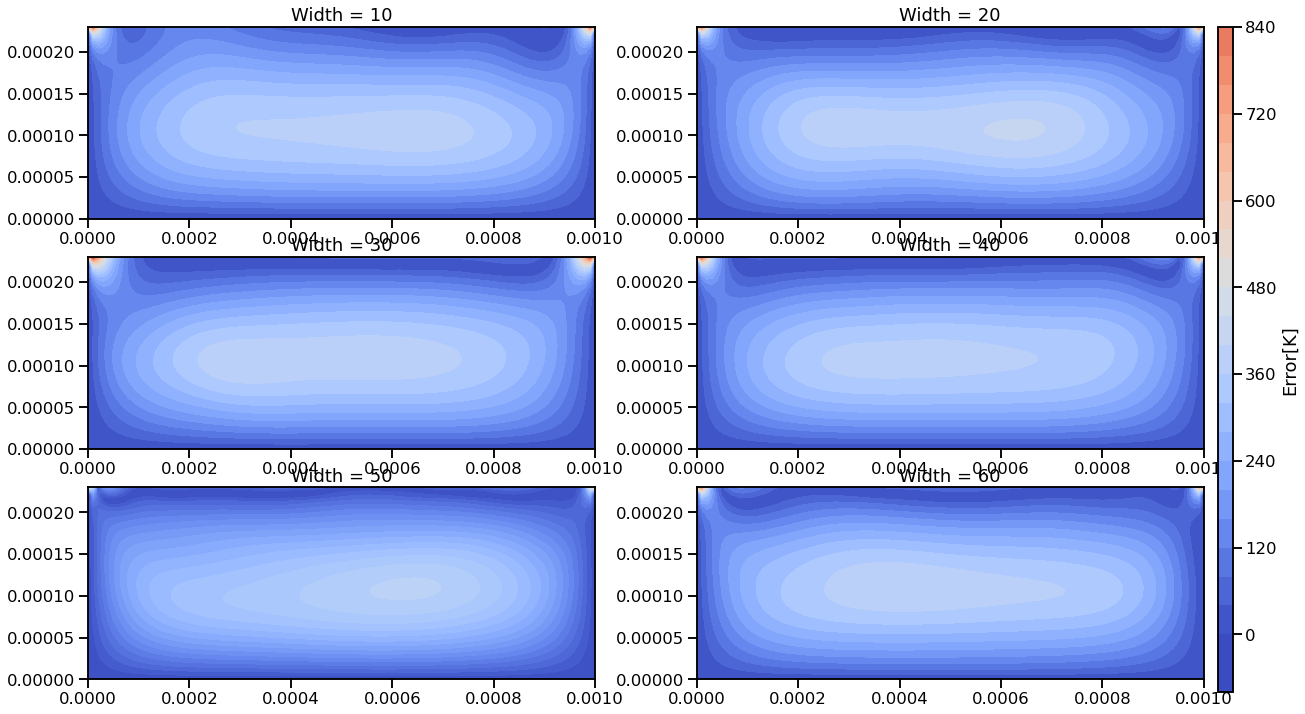

In [2]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 12))

losses = []

for width, ax in zip([10, 20, 30, 40, 50, 60], (ax1, ax2, ax3, ax4, ax5, ax6)):
   
    dde.config.set_random_seed(12345)
    
    data = dde.data.TimePDE(domain,
                       pde_system,
                       ic_bcs = [top],
                       num_domain = 0,
                       num_initial = 0,
                       num_boundary = 0,
                       train_distribution="Hammersley",
                       num_test = 1000,
                       anchors=input_data)
    
    net = dde.nn.FNN([3] + [width] * 6 + [1], "sin", "Glorot normal")
    net.apply_feature_transform(feature_transform)
    net.apply_output_transform(modify_output)

    model = dde.Model(data, net)
    model.compile("adam", lr=1e-3)

    losshistory, train_state = model.train(iterations=0, display_every=1000)
    weights = 1/np.array(losshistory.loss_train[0])
    
    dde.optimizers.config.set_LBFGS_options(maxcor=100, maxiter=1000, maxfun = 1000, maxls=50)
    model.compile('L-BFGS', loss_weights=weights*np.array([1, 10]))
    
    losshistory, train_state = model.train(display_every=10)
    
    Y = model.predict(X)
    predict = griddata((np.ravel(x), np.ravel(y)), np.abs(Y[:,0]-T), (xi[None,:], yi[:,None]), method='cubic')
    im = ax.contourf(xi, yi, predict, 25, cmap=plt.cm.coolwarm, vmin=0, vmax=1000)
    
    ax.set_title('Width = {}'.format(width))
    if ax == ax1:
        cbar_ax = fig.add_axes([0.91, 0.11, 0.01, 0.77])
        fig.colorbar(im, cax=cbar_ax)
        cbar_ax.set_ylabel('Error[K]')
    
    losses.append(losshistory)

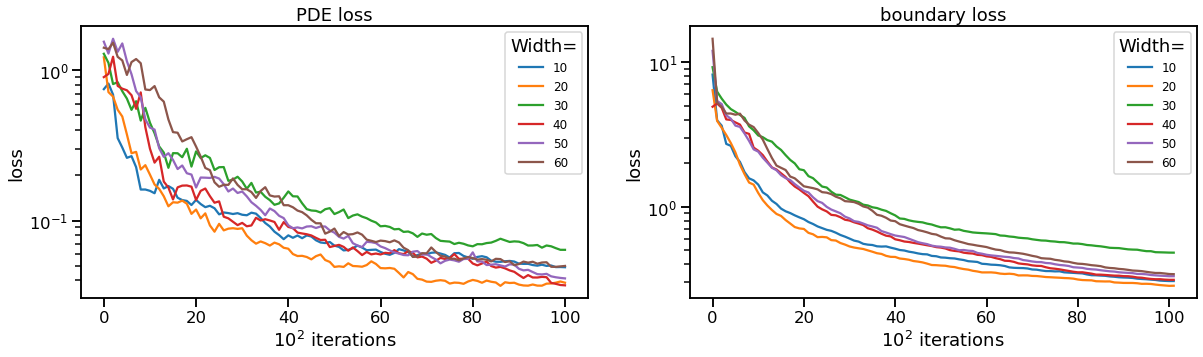

In [5]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20, 5))

ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.set_xlabel(r'$10^2$ iterations')
ax2.set_xlabel(r'$10^2$ iterations')
ax1.set_ylabel('loss')
ax2.set_ylabel('loss')

for loss, width in zip(losses ,[10, 20, 30, 40, 50, 60]):
    
    ax1.plot(np.array(loss.loss_train).T[0, 2:], label = width)
    ax2.plot(np.array(loss.loss_train).T[1, 1:], label = width)
    
#ax1.legend(title = 'Depth=', ncol=6, bbox_to_anchor= (2.12, -0.25))
ax1.legend(title = 'Width=', fontsize = 12)
ax2.legend(title = 'Width=', fontsize = 12)
ax1.set_title('PDE loss')
ax2.set_title('boundary loss')
plt.savefig('parameter_pics/width_loss.pdf', bbox_inches='tight')
plt.show()